In [1]:
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat
from torchvision import transforms
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [2]:
files_train = get_image_files("data/UTK/utkface_aligned_cropped/UTKFace/")
files_valid = get_image_files("data/UTK/utkface_aligned_cropped/crop_part1/")

In [3]:
len(files_train), len(files_valid)

(23708, 9779)

In [4]:
sample_name=files_train[0].name
print(sample_name)

100_0_0_20170112213500903.jpg.chip.jpg


In [5]:
re.findall(r"\d{1,3}_\d_\d",sample_name)[0]

'100_0_0'

In [6]:
type(files_train)

list

In [7]:
df_train = pd.DataFrame(files_train, columns=['name'])
df_train.name = df_train.name.apply(str)
df_train['label'] = df_train.name.apply(lambda x : re.findall("\d{1,3}_\d_\d",x)[0])
df_train['label'] = df_train.label.apply(lambda x : re.sub("_", " ", x))
df_train['age'] = df_train.label.apply(lambda x : int(x.split(" ")[0]))
df_train['gender'] = df_train.label.apply(lambda x : int(x.split(" ")[1]))
df_train['ethnicity'] = df_train.label.apply(lambda x : int(x.split(" ")[2]))

In [8]:
df_valid = pd.DataFrame(files_valid,columns=["name"])
df_valid.name = df_valid.name.apply(str)
df_valid["label"] = df_valid.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_valid["label"] = df_valid.label.apply(lambda x: re.sub("_"," ", x))
df_valid["age"] = df_valid.label.apply(lambda x: int(x.split(" ")[0]))
df_valid["gender"] = df_valid.label.apply(lambda x: int(x.split(" ")[1]))
df_valid["ethnicity"] = df_valid.label.apply(lambda x: int(x.split(" ")[2]))

In [9]:
df_train.head()

,name,label,age,gender,ethnicity
0,data\UTK\utkface_aligned_cropped\UTKFace\100_0...,100 0 0,100,0,0
1,data\UTK\utkface_aligned_cropped\UTKFace\100_0...,100 0 0,100,0,0
2,data\UTK\utkface_aligned_cropped\UTKFace\100_1...,100 1 0,100,1,0
3,data\UTK\utkface_aligned_cropped\UTKFace\100_1...,100 1 0,100,1,0
4,data\UTK\utkface_aligned_cropped\UTKFace\100_1...,100 1 0,100,1,0


# 2. Creating the Datasets, Dataloaders and Databunch

In [10]:
class MultiTaskDataset(Dataset):
    def __init__(self,df, tfms, size=64):
        self.paths = list(df.name)
        self.labels = list(df.label)
        self.tfms = tfms
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = PIL.Image.open(self.paths[idx]).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.tfms, size = self.size)
        img = self.norm(img.data)

        #dealing with the labels
        labels = self.labels[idx].split(" ")
        age = torch.tensor(float(labels[0]), dtype=torch.float32)
        gender = torch.tensor(int(labels[1]), dtype=torch.int64)
        ethnicity = torch.tensor(int(labels[2]), dtype=torch.int64)
        
        return img.data, (age.log_()/4.75, gender, ethnicity)

    def show(self,idx):
        x,y = self.__getitem__(idx)
        age,gender,ethnicity = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {} {}".format(int(age.mul_(4.75).exp_().item()), gender.item(), ethnicity.item()))

In [11]:
tfms = get_transforms()
train_ds = MultiTaskDataset(df_train, tfms[0], size=64)
valid_ds = MultiTaskDataset(df_valid, tfms[1], size=64)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True, num_workers=0)
data = DataBunch(train_dl, valid_dl)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=True, num_workers=0)

In [12]:
class MultiTaskMokdel(nn.Module):
    def __init__(self, arch, ps=0.5):
        super(MultiTaskMokdel,self).__init__()
        self.encoder = create_body(arch)
        self.fc1 = create_head(1024, 1, ps=ps)
        self.fc2 = create_head(1024, 2, ps=ps)
        self.fc3 = create_head(1024, 5, ps=ps)
        
    def forward(self,x):
        
        
        x=self.encoder(x)
        age = torch.sigmoid(self.fc1(x))
        gender = self.fc2(x)
        ethnicity = self.fc3(x)
        
        return [age, gender, ethnicity]

In [13]:
class MultiTaskWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))
        
    def forward(self, preds, y):
        mse, crossEntropy = MSELossFlat(), CrossEntropyFlat()
        age = y[0]
        gender = y[1]
        ethnicity = y[2]
        
        sages =(age*4.75).exp_()
        idx1 = (sages<20) |((sages >40) & (sages <= 60))
        idx2 = sages >60
        loss0 = mse(preds[0],age) + 2*mse(preds[0][idx1],age[idx1]) + 3*mse(preds[0][idx2],age[idx2])
        #loss0 = mse(preds[0], age) + 2*mse(preds[0][idx1],age[idx1]) + 3*mse(preds[0][idx2],age[idx2])
        #trying to account for the imbalance
        
        loss1 = crossEntropy(preds[1], gender)
        loss2 = crossEntropy(preds[2], ethnicity)
        
        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0 * loss0 + self.log_vars[0]
        
        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1 * loss1 + self.log_vars[1]
        
        precision2 = torch.exp(-self.log_vars[2])
        loss2 = precision2 * loss2 + self.log_vars[2]
        
        return loss0 + loss1 + loss2

In [14]:
class MultiTaskWrapper_original(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskWrapper_original, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))
        
    def forward(self, preds, age, gender, ethnicity):
        mse, crossEntropy = MSELossFlat(), CrossEntropyFlat()
        
        sages =(age*4.75).exp_()
        idx1 = (sages<20) |((sages >40) & (sages <= 60))
        idx2 = sages >60
        loss0 = mse(preds[0],age) + 2*mse(preds[0][idx1],age[idx1]) + 3*mse(preds[0][idx2],age[idx2])
        #loss0 = mse(preds[0], age) + 2*mse(preds[0][idx1],age[idx1]) + 3*mse(preds[0][idx2],age[idx2])
        #trying to account for the imbalance
        
        loss1 = crossEntropy(preds[1], gender)
        loss2 = crossEntropy(preds[2], ethnicity)
        
        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0 * loss0 + self.log_vars[0]
        
        precision1 = torch.exp(-self.log_vars[1])
        loss1 = 2*precision1 * loss1 + self.log_vars[1]
        
        precision2 = torch.exp(-self.log_vars[2])
        loss2 = 2*precision2 * loss2 + self.log_vars[2]
        
        return loss0 + loss1 + loss2

In [15]:
model = MultiTaskMokdel(models.resnet34, ps = 0.25)
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
criterion = MultiTaskWrapper(3).to(device)
optimizer_cr = optim.Adam(criterion.parameters(), lr=1e-7, weight_decay=1e-2)
model = model.to(device)

In [16]:
for param in criterion.parameters():
    print(param)

Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)


In [17]:
for param in criterion.parameters():
    print(param.grad)

None


In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
mse=nn.MSELoss()

def train(epoch):
    train_loss = 0
    total = 0
    age_mse = 0
    c_gender = 0
    c_ethics = 0
    for samples in tqdm(train_dl):
        images = samples[0].to(device)
        label = []
        t_label = samples[1]
        labels = [_label.cuda() for _label in t_label] 
        #labels = labels.to(device)
        
        #backwards
        optimizer.zero_grad()
        optimizer_cr.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer_cr.step()
        train_loss += loss.item()
        
        #metrics
        p_age = outputs[0]
        p_gender = outputs[1]
        p_ethics =  outputs[2]
        total += labels[0].size(0)
        
        #age 
        age_mse += mse(p_age, labels[0])
        
        #gender 
        c_gender += (torch.argmax(p_gender,dim=1) == labels[1]).sum().float()
        
        #ethics
        c_ethics += (torch.argmax(p_ethics,dim=1) == labels[2]).sum().float()
        
        
    train_loss =  train_loss * train_dl.batch_size/len(train_dl.dataset)
    m_age_mse = age_mse * train_dl.batch_size/len(train_dl.dataset)
    #m_age_mse = age_mse/total
    acc_gender = 100.* c_gender/total
    acc_ethics = 100.* c_ethics/total
    print('Epoch: {} Train loss: {: .4f}'.format(epoch, train_loss))
    print('Age_mse: {: .4f} Acc_gender {: .4f} Acc_ethics {: .4f}'.format(m_age_mse,acc_gender, acc_ethics))
    return train_loss, m_age_mse,acc_gender, acc_ethics

In [20]:
epochs = 1
import datetime
dt_now = datetime.datetime.now()
exp_time = dt_now.strftime('%Y%m%d_%H:%M:%S')
nb_name='TCGA_Res34_tr_e29'
#writer = SummaryWriter("runs/" +  "." + nb_name + exp_time)

plot_number = 1


for epoch in range(1,epochs + 1):
    train_loss, m_age_mse,acc_gender, acc_ethics = train(epoch)

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:38<00:00,  3.38s/it]

Epoch: 1 Train loss:  3.5705
Age_mse:  0.1009 Acc_gender  51.0461 Acc_ethics  20.5627


In [21]:
for param in criterion.parameters():
    print(param)

Parameter containing:
tensor([-5.3831e-06, -5.5401e-06,  5.5373e-06], device='cuda:0',
       requires_grad=True)


In [22]:
for param in criterion.parameters():
    print(param.grad)

tensor([  1.5438,  10.6727, -36.5462], device='cuda:0')


In [ ]:
epochs =29
import datetime
dt_now = datetime.datetime.now()
exp_time = dt_now.strftime('%Y%m%d_%H:%M:%S')
nb_name='TCGA_Res34_tr_e29'
writer = SummaryWriter("runs/" +  "." + nb_name + exp_time)

plot_number = 1


for epoch in range(1,epochs + 1):
    train_loss,train_acc,train_err_rate = train(epoch)

In [53]:
a = next(iter(train_dl))
images = a[0]
labels = a[1]

In [55]:
images = images.to(device)

In [59]:
label = []
labels_d = [_label.cuda() for _label in labels]

In [60]:
labels_d

[tensor([0.7160, 0.9353, 0.1459, 0.8654, 0.6507, 0.7658, 0.7089, 0.7485, 0.7485,
         0.7424, 0.7424, 0.8398, 0.7766, 0.4626, 0.1459, 0.7015, 0.5701, 0.8359,
         0.7089, 0.6085, 0.7296, 0.9497, 0.1459, 0.7160, 0.7015, 0.8620, 0.6859,
         0.8436, 0.5556, 0.1459, 0.4378, 0.6777, 0.6859, 0.7602, 0.5400, 0.6859,
         0.7160, 0.7015, 0.6859, 0.4378, 0.1459, 0.7229, 0.7296, 0.7713, 0.6410,
         0.7160, 0.0000, 0.7015, 0.7296, 0.6307, 0.5965, 0.5965, 0.7229, 0.8474,
         0.4378, 0.7658, 0.7089, 0.7485, 0.6777, 0.1459, 0.0000, 0.6939, 0.0000,
         0.6859, 0.6939, 0.7544, 0.7160, 0.1459, 0.7485, 0.8359, 0.8756, 0.6859,
         0.7766, 0.9695, 0.6859, 0.7818, 0.8914, 0.6601, 0.6777, 0.6939, 0.8106,
         0.7089, 0.8756, 0.6859, 0.6777, 0.6859, 0.7485, 0.8014, 0.0000, 0.5965,
         0.6859, 0.2919, 0.8788, 0.6859, 0.8398, 0.7485, 0.8584, 0.6777, 0.0000,
         0.4378, 0.0000, 0.7296, 0.7361, 0.7658, 0.7485, 0.7160, 0.6777, 0.6691,
         0.6777, 0.8398, 0.7

# 4. Defining Metrics, Learner and Training

In [58]:
def rmse_age(preds, age, gender, ethnicity) : return root_mean_squared_error(preds[0], age)
def acc_gender(preds, age, gender, ethnicity):return accuracy(preds[1], gender)
def acc_ethnicity(preds, age, gender, ethnicity): return accuracy(preds[2], ethnicity)
metrics = [rmse_age, acc_gender, acc_ethnicity]

In [59]:
model = MultiTaskMokdel(models.resnet34, ps = 0.25)
loss_func = MultiTaskWrapper_original(3).to(data.device) #just making sure the loss is on the gpu
learn =  Learner(data, model, loss_func=loss_func, callback_fns=ShowGraph, metrics=metrics)
learn.split([learn.model.encoder[:6],
             learn.model.encoder[6:],
              nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])
    
])

#first I'll train only the last layer group(the heads)
learn.freeze()

def rmse_age(preds, age, gender, ethnicity): return root_mean_squared_error(preds[0],age)
def acc_gender(preds, age, gender, ethnicity): return accuracy(preds[1], gender)
def acc_ethnicity(preds, age, gender, ethnicity): return accuracy(preds[2], ethnicity)
metrics = [rmse_age, acc_gender, acc_ethnicity]

In [60]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

In [61]:
#spliting the model so that I can use discriminative learning rates
learn.split([learn.model.encoder[:6],
             learn.model.encoder[6:],
             nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])]);

In [62]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24576MB, multi_processor_count=82)

In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


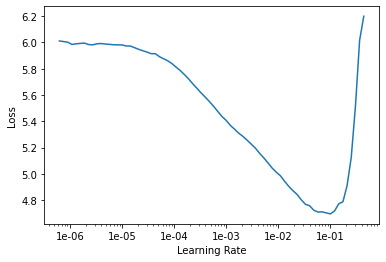

In [64]:
learn.recorder.plot()

In [65]:
1+1

2

epoch,train_loss,valid_loss,rmse_age,acc_gender,acc_ethnicity,time
0,2.163299,1.791126,0.227553,0.748134,0.612742,02:40
1,1.725411,1.412105,0.151442,0.779425,0.688107,01:55
2,1.437735,1.315586,0.136425,0.795378,0.708559,02:02
3,1.257547,1.643032,0.132475,0.812967,0.620309,02:00
4,1.126166,1.115292,0.117910,0.849882,0.742816,01:58
5,1.044270,1.024674,0.132266,0.857041,0.772369,01:57
6,0.989839,1.024061,0.111422,0.856938,0.767665,01:58
7,0.944046,0.990498,0.104841,0.871357,0.751406,01:56
8,0.907322,0.891648,0.098421,0.856632,0.798139,01:57
9,0.874666,0.879312,0.095330,0.880765,0.790367,01:57


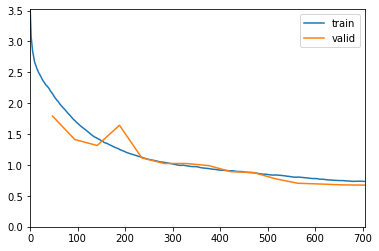

Better model found at epoch 0 with valid_loss value: 1.7911264896392822.
Better model found at epoch 1 with valid_loss value: 1.4121054410934448.
Better model found at epoch 2 with valid_loss value: 1.3155863285064697.
Better model found at epoch 4 with valid_loss value: 1.1152923107147217.
Better model found at epoch 5 with valid_loss value: 1.0246737003326416.
Better model found at epoch 6 with valid_loss value: 1.024060845375061.
Better model found at epoch 7 with valid_loss value: 0.9904983043670654.
Better model found at epoch 8 with valid_loss value: 0.8916481137275696.
Better model found at epoch 9 with valid_loss value: 0.8793119788169861.
Better model found at epoch 10 with valid_loss value: 0.775871992111206.
Better model found at epoch 11 with valid_loss value: 0.7042503356933594.
Better model found at epoch 12 with valid_loss value: 0.6923696398735046.
Better model found at epoch 13 with valid_loss value: 0.6780344843864441.
Better model found at epoch 14 with valid_loss va

In [29]:
learn.fit_one_cycle(15, max_lr = 1e-2,
                   callbacks = [callbacks.SaveModelCallback(learn, every='improvement',
                                                           monitor = 'valid_loss',
                                                           name = 'stage-1')])

In [30]:
learn.load('stage-1')

Learner(data=DataBunch;

Train: <__main__.MultiTaskDataset object at 0x000002CD430C3FD0>;

Valid: <__main__.MultiTaskDataset object at 0x000002CD430AF970>;

Test: None, model=MultiTaskMokdel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
      

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


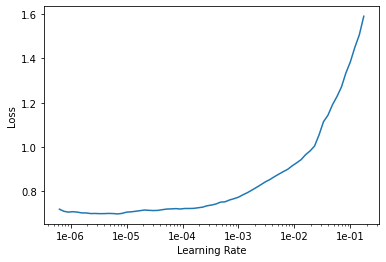

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,rmse_age,acc_gender,acc_ethnicity,time
0,0.720178,0.673043,0.087708,0.900194,0.845894,01:57
1,0.719008,0.668469,0.087249,0.902035,0.846712,01:55
2,0.720455,0.663398,0.086061,0.902853,0.846815,01:54
3,0.716058,0.658480,0.086137,0.904694,0.848655,01:52
4,0.711191,0.645454,0.085113,0.905410,0.854075,01:53
5,0.708421,0.634531,0.084425,0.909398,0.855916,01:53
6,0.701390,0.627505,0.083316,0.911750,0.856632,01:54
7,0.686738,0.618583,0.082853,0.912466,0.857245,01:52
8,0.680406,0.584341,0.081003,0.916760,0.866960,01:51
9,0.668988,0.573070,0.082311,0.916147,0.871868,01:51


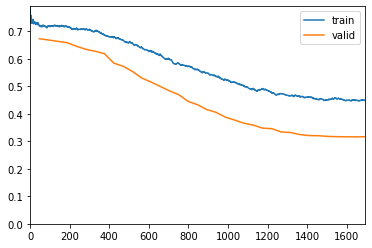

Better model found at epoch 0 with valid_loss value: 0.6730433702468872.
Better model found at epoch 1 with valid_loss value: 0.6684694886207581.
Better model found at epoch 2 with valid_loss value: 0.663398265838623.
Better model found at epoch 3 with valid_loss value: 0.6584796905517578.
Better model found at epoch 4 with valid_loss value: 0.645453929901123.
Better model found at epoch 5 with valid_loss value: 0.634530782699585.
Better model found at epoch 6 with valid_loss value: 0.6275049448013306.
Better model found at epoch 7 with valid_loss value: 0.6185829043388367.
Better model found at epoch 8 with valid_loss value: 0.5843412280082703.
Better model found at epoch 9 with valid_loss value: 0.5730699300765991.
Better model found at epoch 10 with valid_loss value: 0.554376482963562.
Better model found at epoch 11 with valid_loss value: 0.5302241444587708.
Better model found at epoch 12 with valid_loss value: 0.5156602263450623.
Better model found at epoch 13 with valid_loss value

In [32]:
learn.unfreeze()
learn.fit_one_cycle(36,max_lr=slice(1e-6,3e-4),
                   callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

In [33]:
learn = learn.load('stage-2')

# 5. Using the model to inference

In [34]:
trained_model = learn.model.cpu()
torch.save(trained_model.state_dict, 'model_paramas_resnet34_faces')

In [36]:
class AgenethPredictor():
    def __init__(self, model):
        self.model = model
        self.tfms = get_transforms()[1]
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats
        self.gender = {0:"Male",1:"Female"}
        self.ethnicity = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

    def predict(self,x):
        #x is a PIL Image
        x = Image(pil2tensor(x, dtype=np.float32).div_(255))
        x = x.apply_tfms(self.tfms, size = 64)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        age = int(torch.exp(preds[0]*4.75).item())
        gender = self.gender[torch.softmax(preds[1],1).argmax().item()]
        ethnicity = self.ethnicity[torch.softmax(preds[2],1).argmax().item()]
        return age, gender, ethnicity

In [37]:
ageneth_predictor = AgenethPredictor(trained_model)

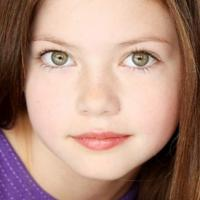

In [38]:
img  = PIL.Image.open(df_valid.name.iloc[100])
img

In [39]:
df_valid.name.iloc[100]

'..\\data\\UTK\\utkface_aligned_cropped\\crop_part1\\10_1_0_20170109203642966.jpg.chip.jpg'

In [41]:
ageneth_predictor.predict(img)

(13, 'Female', 'White')